<a href="https://colab.research.google.com/github/tcaba2/Comp-Astro2024/blob/main/Tutorial%205/Tutorial_5_Innovation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import math
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#Implementing the multi-head attention mechanism
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.d_model = d_model #The dimensionality of the model (embedding size)
        self.num_heads = num_heads #The number of attention heads.
        self.d_k = d_model // num_heads #Calculates the dimensionality of each head

        #Linear transformation layers to project the input queries, keys, values, and output of each attention head to the desired dimension.

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask=None):

     # Computes attention scores by performing matrix multiplication between queries (Q) and keys (K), scaled by the square root of the dimension of keys (d_k).
     #Applies the mask (if provided) to the attention scores to mask out padded values.
     #Computes attention probabilities using softmax.
     #Multiplies the attention probabilities with values (V) to get the output.
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)
        attn_probs = torch.softmax(attn_scores, dim=-1)
        output = torch.matmul(attn_probs, V)
        return output



    def split_heads(self, x):

      #Reshapes the input tensor x into a 4D tensor with dimensions [batch_size, seq_length, num_heads, d_k].
      #Transposes the dimensions to move the num_heads dimension to the correct position.
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)

    def combine_heads(self, x):

      #Transposes the dimensions of the input tensor to move the num_heads dimension to the correct position.
      #Reshapes the tensor to combine the heads into a single tensor.
        batch_size, _, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)

    def forward(self, Q, K, V, mask=None):
      #Projects the input queries, keys, and values using linear transformation layers (self.W_q, self.W_k, self.W_v).
      #Splits the projected tensors into multiple heads.
      #Applies scaled dot-product attention to compute the output of each head.
      #Combines the outputs of all heads and projects them back to the original dimensionality using the output linear transformation layer (self.W_o).
      #Returns: The output tensor of the multi-head attention layer.
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))

        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)
        output = self.W_o(self.combine_heads(attn_output))
        return output

In [ ]:
class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PositionWiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_output, src_mask, tgt_mask):
        attn_output = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(attn_output))
        attn_output = self.cross_attn(x, enc_output, enc_output, src_mask)
        x = self.norm2(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))
        return x

In [ ]:
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout):
        super(Transformer, self).__init__()
        self.encoder_embedding = nn.Embedding(src_vocab_size, d_model)
        self.decoder_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)

        self.encoder_layers = nn.ModuleList(
            [EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.decoder_layers = nn.ModuleList(
            [DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

        self.fc = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def generate_mask(self, src, tgt):
        src_mask = (src != 0).unsqueeze(1).unsqueeze(2)
        tgt_mask = (tgt != 0).unsqueeze(1).unsqueeze(2)
        seq_length = tgt.size(-1)
        nopeak_mask = (1 - torch.triu(torch.ones(1, 1, seq_length), diagonal=1)).bool()
        tgt_mask = tgt_mask & nopeak_mask
        return src_mask, tgt_mask

    def forward(self, src, tgt):
        src_mask, tgt_mask = self.generate_mask(src, tgt)
        src_embedded = self.dropout(self.positional_encoding(self.encoder_embedding(src)))
        tgt_embedded = self.dropout(self.positional_encoding(self.decoder_embedding(tgt)))
        enc_output = src_embedded
        for enc_layer in self.encoder_layers:
            enc_output = enc_layer(enc_output, src_mask)

        dec_output = tgt_embedded
        for dec_layer in self.decoder_layers:
            dec_output = dec_layer(dec_output, enc_output, src_mask, tgt_mask)

        output = self.fc(dec_output)
        return output

In [ ]:
df = pd.read_csv('a_catalog.csv')
pd.set_option('display.max_columns', None)  # Display all columns
pd.set_option('display.expand_frame_repr', False)

df.drop('name_s', axis=1, inplace=True)
df.drop('id', axis=1, inplace=True)
df.drop('nuniverse', axis=1, inplace=True)

scaler_number = 20000
scaler = MinMaxScaler(feature_range=(0, scaler_number))
columns_to_scale = [col for col in df.columns if col != 'stype']
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

In [ ]:
data = pd.get_dummies(df, columns=['stype']).astype(int)
data.reset_index(drop=True, inplace=True)

In [ ]:
min_max_df = pd.DataFrame({
    'Min': data.min(),
    'Max': data.max()
}).transpose()

# If you want to preserve the original column order
min_max_df = min_max_df[data.columns]
# print(min_max_df)

flag = np.random.randint(0, 2, size=data.shape[0])

In [ ]:
encoded_data_train, remaining_data_test, flag_train, remaining_flag_test = train_test_split(
    data, flag, train_size=0.7, random_state=42)

In [ ]:
encoded_data_test, encoded_data_val, flag_test, flag_val = train_test_split(
    remaining_data_test, remaining_flag_test, test_size=0.5, random_state=42)

In [ ]:
encoded_data_train = torch.tensor(encoded_data_train.values, dtype=torch.long)
flag_train = torch.tensor(flag_train, dtype=torch.long)

In [ ]:
encoded_data_test = torch.tensor(encoded_data_test.values, dtype=torch.long)
flag_test = torch.tensor(flag_test, dtype=torch.long)

In [ ]:
encoded_data_val = torch.tensor(encoded_data_val.values, dtype=torch.long)
flag_val = torch.tensor(flag_val, dtype=torch.long)

In [ ]:
src_vocab_size = scaler_number + 1
tgt_vocab_size = 2
d_model = 128
num_heads = 1
num_layers = 2
d_ff = 32
max_seq_length = 48
dropout = 0.1
epoch_num = 30

transformer = Transformer(src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

train_losses = []
val_losses = []
test_losses = []

In [ ]:
transformer.train()
for epoch in range(epoch_num):
    optimizer.zero_grad()
    output = transformer(encoded_data_train, flag_train.unsqueeze(1))
    flag_train_dim = torch.cat((1 - flag_train.view(-1, 1), flag_train.view(-1, 1)), dim=1)
    loss = criterion(output.contiguous().view(-1, tgt_vocab_size), flag_train_dim.float())
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    print(f"Epoch: {epoch + 1}, Loss: {loss.item()}")

    if (epoch + 1) % 10 == 0:
        transformer.eval()
        with torch.no_grad():
            val_output = transformer(encoded_data_val, flag_val.unsqueeze(1))
            val_flag_dim = torch.cat((1 - flag_val.view(-1, 1), flag_val.view(-1, 1)), dim=1)
            val_loss = criterion(val_output.contiguous().view(-1, tgt_vocab_size), val_flag_dim.float())
            val_losses.append(val_loss.item())
            print(f"Validation Loss: {val_loss.item()}")

        transformer.train()

transformer.eval()
with torch.no_grad():
    test_output = transformer(encoded_data_test, flag_test.unsqueeze(1))
    test_flag_dim = torch.cat((1 - flag_test.view(-1, 1), flag_test.view(-1, 1)), dim=1)
    test_loss = criterion(test_output.contiguous().view(-1, tgt_vocab_size), test_flag_dim.float())
    test_losses.append(test_loss.item())
    print(f"Testing Loss: {test_loss.item()}")


Epoch: 1, Loss: 0.366619348526001
Epoch: 2, Loss: 0.34632036089897156
Epoch: 3, Loss: 0.3257986307144165
Epoch: 4, Loss: 0.3073262572288513
Epoch: 5, Loss: 0.28906959295272827
Epoch: 6, Loss: 0.2708827555179596
Epoch: 7, Loss: 0.2548356056213379
Epoch: 8, Loss: 0.23858855664730072
Epoch: 9, Loss: 0.22313493490219116
Epoch: 10, Loss: 0.20874959230422974
Validation Loss: 0.16361702978610992
Epoch: 11, Loss: 0.1947011798620224
Epoch: 12, Loss: 0.1819661408662796
Epoch: 13, Loss: 0.16944660246372223
Epoch: 14, Loss: 0.15835291147232056
Epoch: 15, Loss: 0.14826032519340515
Epoch: 16, Loss: 0.13787798583507538
Epoch: 17, Loss: 0.12848669290542603
Epoch: 18, Loss: 0.11995093524456024
Epoch: 19, Loss: 0.11181794852018356
Epoch: 20, Loss: 0.10439383238554001
Validation Loss: 0.07461021095514297
Epoch: 21, Loss: 0.09754619002342224
Epoch: 22, Loss: 0.09108036011457443
Epoch: 23, Loss: 0.08532501757144928
Epoch: 24, Loss: 0.07954958081245422
Epoch: 25, Loss: 0.07452034950256348
Epoch: 26, Loss: 0

## Innovation

Analyze the model’s performance using appropriate metrics (e.g., accuracy, precision, recall).

Testing Loss: 0.0370279923081398
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Confusion Matrix:
[[1056    0]
 [   0 1045]]


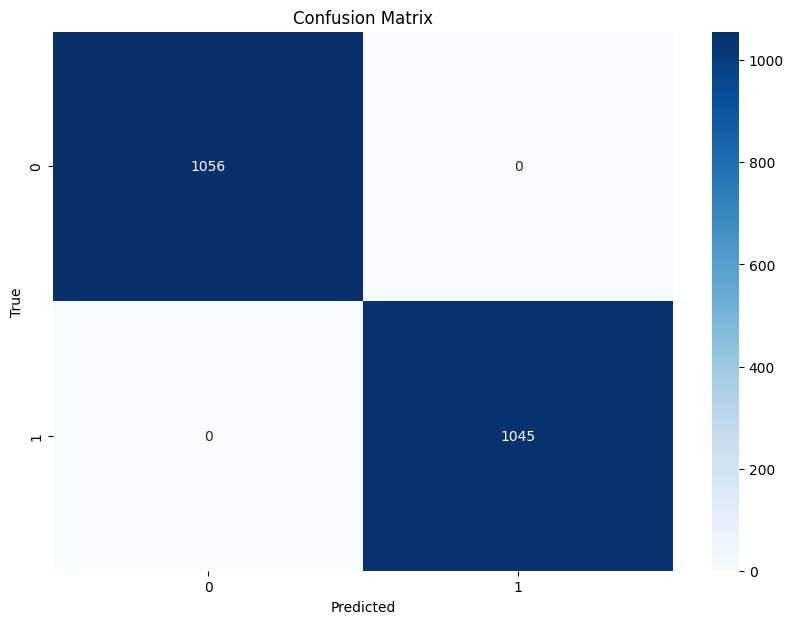

In [47]:
#evaluation of the model's performance on the testing data
# set the model to evaluation mode to disable dropout and other training-specific layers
transformer.eval()
with torch.no_grad():
    test_output = transformer(encoded_data_test, flag_test.unsqueeze(1))
    test_flag_dim = torch.cat((1 - flag_test.view(-1, 1), flag_test.view(-1, 1)), dim=1)
    test_loss = criterion(test_output.contiguous().view(-1, tgt_vocab_size), test_flag_dim.float())
    test_losses.append(test_loss.item())
    print(f"Testing Loss: {test_loss.item()}")

    # Convert output to probabilities and get predictions
    test_probs = torch.sigmoid(test_output) #converts logits output by model into probabilities
    test_preds = torch.argmax(test_probs, dim=-1).squeeze() #get the predicted class by finding the index with the maximum probability

    # Calculate metrics using sklearn.metrics
    accuracy = metrics.accuracy_score(flag_test, test_preds)
    precision = metrics.precision_score(flag_test, test_preds)
    recall = metrics.recall_score(flag_test, test_preds)
    f1_score = metrics.f1_score(flag_test, test_preds) #useful for imbalanced datasets
    # harmonic mean of precision and recall (1=best, 0=worst)
    conf_matrix = confusion_matrix(flag_test, test_preds)

    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1_score}")
    print(f"Confusion Matrix:\n{conf_matrix}")

    # Visualize the results by plotting heatmap
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


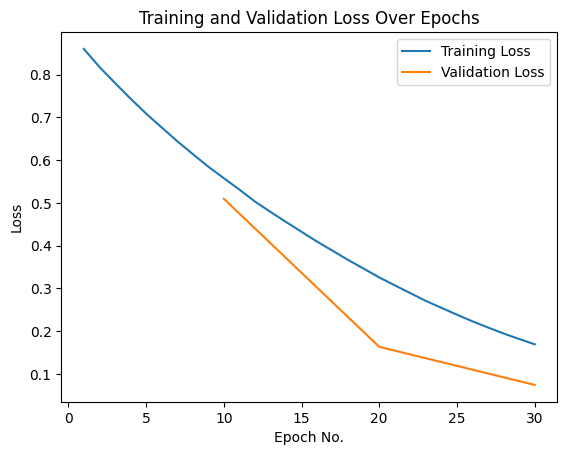

In [53]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming train_losses and val_losses are being recorded correctly
# Plot loss as a function of epoch
epoch_range = np.arange(1, epoch_num + 1)  # Create a range for the number of epochs

# Ensure train_losses and val_losses have the correct lengths
train_losses = train_losses[:epoch_num]
val_losses_epochs = list(range(10, epoch_num + 1, 10))  # Validation losses were logged every 10 epochs
val_losses = val_losses[:len(val_losses_epochs)]

# Plotting training and validation losses
plt.plot(epoch_range, train_losses, label='Training Loss')
plt.plot(val_losses_epochs, val_losses, label='Validation Loss')

plt.legend()
plt.xlabel('Epoch No.')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.show()